<a href="https://colab.research.google.com/github/rontalapoojareddy/DeepLearning1/blob/main/DL_Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision transformers pillow tqdm


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os


In [3]:
from transformers import BertTokenizer, BertModel

class TextEncoder(nn.Module):
    def __init__(self, embed_dim=256):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(768, embed_dim)

    def forward(self, text_inputs):
        outputs = self.bert(**text_inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        return self.fc(cls_embedding)


In [4]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, text_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim + text_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 3 * 64 * 64),
            nn.Tanh()
        )

    def forward(self, noise, text_embedding):
        x = torch.cat((noise, text_embedding), dim=1)
        img = self.net(x)
        return img.view(-1, 3, 64, 64)


In [5]:
class Discriminator(nn.Module):
    def __init__(self, text_dim=256):
        super().__init__()
        self.img_fc = nn.Linear(3 * 64 * 64, 512)
        self.text_fc = nn.Linear(text_dim, 512)
        self.out = nn.Linear(1024, 1)

    def forward(self, img, text_embedding):
        img = img.view(img.size(0), -1)
        img_feat = self.img_fc(img)
        text_feat = self.text_fc(text_embedding)
        x = torch.cat((img_feat, text_feat), dim=1)
        return torch.sigmoid(self.out(x))


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

G = Generator().to(device)
D = Discriminator().to(device)
T = TextEncoder().to(device)

criterion = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=0.0002)
opt_D = optim.Adam(D.parameters(), lr=0.0002)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [8]:
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt

# Load pretrained model
model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16
)

device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)




Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

merges.txt: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Enter text description for image generation: real mountain sunny
How many images to generate?: 3


  0%|          | 0/50 [00:00<?, ?it/s]

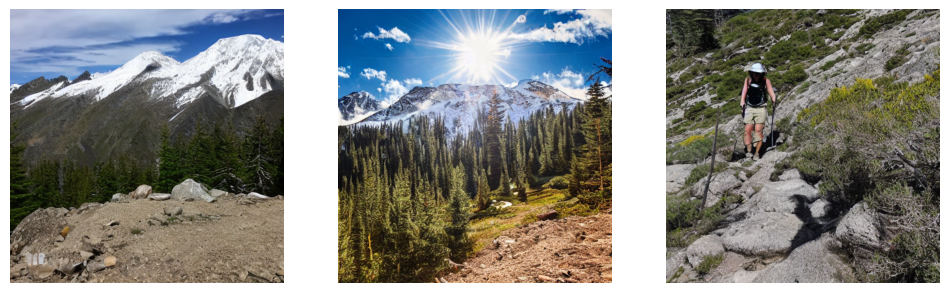

In [11]:
# -------- DYNAMIC USER INPUT --------
prompt = input("Enter text description for image generation: ")

num_images = int(input("How many images to generate?: "))

# Generate images
result = pipe(
    prompt,
    num_images_per_prompt=num_images
)

images = result.images

# Display images
plt.figure(figsize=(12, 6))
for i, img in enumerate(images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    plt.axis("off")
    img.save(f"generated_{i}.png")

plt.show()